# Tutorial: 1D FEM Model of an Impedance Tube
Author: [Jonathan Hargreaves](https://www.salford.ac.uk/our-staff/jonathan-hargreaves)

This tutorial aims to introduce the basic concepts of FEM for the simplest acoustic model possible: 1D propagation of sound in a tube. This model has the benefit of being grounded in reality too - it simulates the acoustic behaviour in an <b>Impedance Tube</b>, as are used to measure the acoustic properties of materials. This measurement processes is standardised in ISO 10534-1:1996.

Our model will be simpler than the real thing, however:
* We'll assume that pressure and [particle velocity](https://en.wikipedia.org/wiki/Particle_velocity) are invariant over the cross-section of the tube, i.e., the possibility of circumferential or radial variation is ignored. This means we can model the system as a 1D interval - it's only argument is position $x$ along the tube;
* We will ignore structural transmission in the tube - this will be a model solely of the acoustic waves in the air in the tube;
* We won't model the interior of the absorption material - we will instead represent it by a boundary admittance.

Being 1D, the model is sufficiently simple that we can easily write out the equations, draw diagrams of the interpolation functions, and plot results. You will also see how this leads to a matrix equation, with predictable sparsity patterns, which we'll then solve to find the solution to the problem. This is a set of pressure coefficients at the mesh nodes, which are interpolated over the intervening elements to give a solution everywhere.

We will do this both for driven behaviour at a user-defined frequency (a <i>Frequency Response</i> study) and to find the undriven natural modes of the tube (an <i>eigenfrequency study</i>). Finally, we will compare the FEM solution to an analytical model so we can compute the RMS error and study solution convergence.

## Problem statement

An impedance tube, also called a plane wave tube, is convenient because it is designed such that pressure should only vary along the tube; it should be invariant of position across the tube. Similarly, particle velocity should only be up and down the tube, with not circumferential or radial component. This allows us to model it in 1D.

![Tube diagram](tubediag.jpg)

### Physical description
The system comprises:
* A vibrating loudspeaker on the left at $x=0$;
* A 1m long air-filled rigid tube forming the domain $0\leq x\leq1$;
* An absorbing material – the test sample – on the right, with its front surface is at $x=1$.
We assume that pressure $U(x,t)$ can be measured anywhere in the tube; this is straightforward in FEM, but in a real tube would require use of a ‘probe microphone’ as depicted above. Knowing this data means we can compute RMS error versus our reference solution.
We assume that the loudspeaker is producing a pure tone at angular frequency $\omega$, and moving with amplitude $U_0$. This is a velocity boundary condition, and the motion of the cone follows $U(0,t)=\Re\left[U_0\mathrm{e}^{-\mathrm{i}\omega t}\right]$.

We assume that all quantities vary time-harmonically with the excitation. This makes this a Frequency Domain problem. Because of this, we can express all our quantities as complex amplitude, which I’ll write uppercase, instead of time-domain signals. So we’ll solve for complex pressure amplitude $u(x)$ versus position, but the time-domain signal could be readily reconstructed from this using $U(x,t)=\Re\left[u(x)\mathrm{e}^{-\mathrm{i}\omega t}\right]$ if required. The solution $u(x)$ will be different for different frequencies.

The air in the tube has wavespeed $c$ and density $\rho_0$. We assume that is obeys the linear wave equation {eq}`eq-wave-eq`. Combined with our time-harmonic asumption, we will obtain the Helmholtz equation, as in [this derivation](../../core-concepts/how-define-problem-what-is-a-pde.md).

The purpose of an impedance tube is to measure the surface impedance of a test sample. But here we are just using it as a context to motivate our FEM model, so we’ll assume the specific surface impedance $Z_s$ of the test sample is known. Impedance can be troublesome in numerical methods however, since it takes an infinite value for rigid boundaries, as are commonly used in Acoustics. To mitigate this, we instead use its reciprocal, admittance. Moreover, we will use admittance that has been normalised to the characteristic impedance of air: $Y_n=\rho_0c/Z_s$. A rigid boundary has $Y_n=0$ and an anechoic termination has $Y_n=1$.

### Mathematical formulation

We model as a 1D [Helmholtz problem](../../core-concepts/how-define-problem-acoustics-pdes.md#The-Helmholtz-Equation):

$$
\frac{\mathrm{d}^2u}{\mathrm{d} x^2}(x) + k^2u(x) = 0,\quad 0\leq x \leq 1,
$$

with boundary conditions

$$
\frac{\mathrm{d} u}{\mathrm{d} x}(0) = \mathrm{i}\omega \rho_0 U_0,\quad \frac{\mathrm{d} u}{\mathrm{d} x}(1) = \mathrm{i} k Y_n u(1).
$$

## Finding the weak form
First we multiply our differential equation by a test function $Q(x)$ and integrated over the modelling domain (the length of the tube)

$$
\int_{0}^{1} \frac{{d^{2} u}}{{d{x}^{2}}} \left(x\right) Q\left(x\right) dx + k^{2} \int_{0}^{1} u\left(x\right) Q\left(x\right) dx = 0
$$

The first term can be integrated by parts to give:

$$
\frac{{du}}{{dx}}(1) Q(1) - \frac{{du}}{{dx}}(0) Q(0) - \int_{0}^{1} \frac{{du}}{{dx}}(x) \frac{{dQ}}{{dx}}(x) dx + k^{2} \int_{0}^{1} u(x) Q(x) dx = 0
$$

We can substitute our boundary conditions into the statements at  and  to obtain our weak form of the problem:

$$
\mathrm{i}k {Y}_{n} u(1) Q(1) - \mathrm{i} \omega \rho_{0} U_{0} Q(0) - \int_{0}^{1} \frac{du}{dx}(x) \frac{dQ}{dx}(x) dx + k^{2} \int_{0}^{1} u(x) Q(x) dx = 0
$$

### Discretisation, interpolation and numerical solution
To solve the problem numerically using a computer we must discretise it. To do this we define a grid of $N+1$ regularly spaced nodes $x_n:=n/N$, where  is an integer which satisfies $0\leq\leq N$. The element size $h$ is given by:

$$
h:=\max_{1\leq n\leq N}(x_n-x_{n-1})
$$

he elements lie between sequential pairs of nodes. We will assume that pressure is interpolated linearly on each element between each nodal point. This can be written neatly using two linear basis functions:  for  (see figure above right). In practice each nodal value is shared between two elements, so it is more convenient to write the basis functions as triangle functions defined as:

$$
u(x) = u(x_{n}) b_{n}(x) + u(x_{n+1}) b_{n+1}(x),\quad\text{for }x_n<x<x_{n+1}.
$$

In practice each nodal value is shared between two elements, so it is more convenient to write the basis functions as triangle functions defined as:

$$
b_{n}(x) = \begin{cases} \frac{x - x_{n-1}}{h} & x_{n-1} \leq x \leq x_{n} \\ \frac{x_{n+1} - x}{h} & x_{n} \leq x \leq x_{n+1} \\ 0 & \text{otherwise} \end{cases}
$$

The only exceptions are the two end elements $b_0$ and $b_N$, which are half-triangles due to us only modelling the domain $0\leq x \leq1$. An example for $N=8$ is shown below.

![Mesh](tubemesh.jpg)

We can now write a complete expression for $u$ as a weighted sum of the basis functions:

$$
u(x) = \sum_{n=0}^{N} u_{n} b_{n}(x),
$$

where $u_n=u(x_n)$ are the nodal values which we solve for. We will do this by substituting this representation into our weak form equation, and then insisting that is satisfied for any choice of $Q$ which is also a weighted sum of the same basis functions. This amounts to requiring that the following holds for all $m$:

$$
\sum_{n=0}^{N} \left[ u_{n} \left( \mathrm{i} k {Y}_{n} b_{m}(1) b_{n}(1) - \int_{0}^{1} \frac{d b_{n}}{dx}(x) \frac{d b_{m}}{dx}(x) dx + k^{2} \int_{0}^{1} b_{n}(x) b_{m}(x) dx \right) \right] \\= \mathrm{i} k \rho_{0} c U_{0} b_{m}(0)
$$

This can be written as a matrix equation, which can be solved numerically to find $u$:

$$
(\mathrm{i} k D - K + k^{2} M) \mathbf{u} = \mathrm{i} k w,
$$

where $\mathbf{u}$ is a vector of pressure nodal values $u_m=u(x_m)$.

For our problem, the *dampening matrix* $D$  has elements:

$$
D_{m,n} = Y_nb_m(1)b_n(1)
$$

The *stiffness matrix* $k$ has elements:

$$
K_{m,n} = \int_{0}^{1} \frac{d b_{n}}{dx}(x) \frac{d b_{m}}{dx}(x) dx
$$

The *mass matrix* $M$ has elements:

$$
K_{m,n} = \int_{0}^{1} {b_{n}
}(x) {b_{m}}(x) dx
$$

The work vector $w$ has elements:

$$
w_m = \rho_0 c U_0 b_m(0)
$$



In [1]:
import numpy as np

# Acoustical parameters:
f = 2000           # Frequency in Hertz
c = 343          # Speed of sound in air in meters per second
rho0 = 1.21        # Density of air in kg/m^3
k = 2 * np.pi * f / c      # Wavenumber in radians per meter
Yn = 1.0           # Normalised specific admittance of material at x=1
U0 = 0.001         # Amplitude of piston velocity (m/s)

# Mesh parameters:
N = 100            # Number of elements
h = 1 / N            # Element size
x = np.arange(0, 1 + h / 100, h / 100)      # Array of x values to compare FEM and analytical models at

## Evaluation of matrix entries

Since $b_m(1)$ and $b_n(1)$ are only non-zero for $m=n=N$, our damping matrix $D$ only has one non-zero entry in the bottom right-hand corner:

$$
D_{m,n} = \begin{cases} Y_{n} & m=n=N \\ 0 & \text{otherwise} \end{cases}
$$

Similarly, the work vector only has one non-zero because $b_m(0)$ is only non-zero for $n=0$:

$$
w_{m} = \begin{cases} \rho_{0} c U_{0} & m=0 \\ 0 & \text{otherwise} \end{cases}
$$

$K$ and $M$ are also sparse because of the compact overlap of the basis functions. They both have a tri-diagonal form, and the values on the diagonals are all equal because we used a mesh with a uniform element size $h=1/N$. Usually in FEM these integrals would be evaluated numerically, but this test case is so simple that they can be evaluated by hand (see below). The resulting values are:

$$
K = \begin{bmatrix} 
\frac{1}{h} & -\frac{1}{h} & 0 & \cdots & 0 \\
-\frac{1}{h} & \frac{2}{h} & -\frac{1}{h} & \cdots & 0 \\
0 & -\frac{1}{h} & \frac{2}{h} & \ddots & 0 \\
\vdots & \vdots & \ddots & \ddots & -\frac{1}{h} \\
0 & 0 & 0 & -\frac{1}{h} & \frac{1}{h} 
\end{bmatrix},
M = \begin{bmatrix} 
\frac{h}{3} & \frac{h}{6} & 0 & \cdots & 0 \\
\frac{h}{6} & \frac{2h}{3} & \frac{h}{6} & \cdots & 0 \\
0 & \frac{h}{6} & \frac{2h}{3} & \ddots & 0 \\
\vdots & \vdots & \ddots & \ddots & \frac{h}{6} \\
0 & 0 & 0 & \frac{h}{6} & \frac{h}{3} 
\end{bmatrix}
$$

Most of the matrix entries in each diagonal ‘band’ are equal. The only exceptions are the end diagonal elements. Here, half the basis function is missing so the value is halved.

### Mass matrix entries
The off-diagonal entries arise due to overlap of elements. They are the product of one ‘rising’ basis function with another 'falling' one. These produce integrals of the form:

$$
\int_{0}^{h} \frac{x}{h} \times \frac{h - x}{h} dx = \frac{1}{h^2} \int_{0}^{h} \left( xh - x^2 \right) dx = \frac{1}{h^2} \left[ \frac{x^2h}{2} - \frac{x^3}{3} \right] \bigg|_{0}^{h} = \frac{1}{h^2} \left[ \frac{h^3}{2} - \frac{h^3}{3} \right] = \frac{h}{6}
$$

The diagonal elements arise from basis function self-interaction. These produce integrals of the form:

$$
\int_{0}^{h} \frac{x}{h} \times \frac{x}{h} dx = \frac{1}{h^2} \int_{0}^{h} x^2 dx = \frac{1}{h^2} \left[ \frac{x^3}{3} \right] \bigg|_{0}^{h} = \frac{h}{3},$$
$$
\int_{0}^{h} \frac{h-x}{h} \times \frac{h-x}{h} dx = \\\frac{1}{h^2} \int_{0}^{h} \left[ h^2 - 2xh + x^2 \right] dx = \frac{1}{h^2} \left[ h^2 x - x^2 h + \frac{x^3}{3} \right] \bigg|_{0}^{h} \\= \frac{1}{h^2} \left[ h^3 - h^3 + \frac{h^3}{3} \right] \bigg|_{0}^{h} = \frac{h}{3}
$$

Most basis functions are symmetrical and produce the sum of these two integrals, hence the $2h/3$ values on most of the diagonal. But the end elements only have half the support so produce $h/3$.

### Stiffness matrix entries

To compute the stiffness matrix, we first need to compute $db_n/dx$. This is piecewise-constant, with a positive section where the basis function is rising and a negative section where it is falling:

$$
\frac{d b_n}{dx} (x) = \begin{cases} \frac{1}{h} & x_{n-1} \leq x \leq x_n \\ -\frac{1}{h} & x_n \leq x \leq x_{n+1} \\ 0 & \text{otherwise} \end{cases}
$$

The off-diagonal entries again arise due to overlap of elements, but the integrals are simpler due to the simpler form of $db_n/dx$. These produce integrals of the form:

$$
\int_{0}^{h} \frac{1}{h} \times \frac{-1}{h} dx = -\frac{1}{h^2} \int_{0}^{h} dx = -\frac{1}{h} 
$$

The diagonal elements arise from basis function self-interaction. These produce integrals of the form:

$$
\int_{0}^{h} \frac{1}{h} \times \frac{1}{h} dx = \frac{1}{h^2} \int_{0}^{h} dx = \frac{1}{h},\\
\int_{0}^{h} \frac{-1}{h} \times \frac{-1}{h} dx = \frac{1}{h^2} \int_{0}^{h} dx = \frac{1}{h}
$$

Most basis functions are symmetrical and produce the sum of these two integrals, hence the $2/h$ values on most of the diagonal. But the end elements only have half the support so produce $1/h$.

In [2]:
# Stiffness matrix:
main_diag = (2 / h) * np.diag(np.ones(N + 1))
upper_diag = (-1 / h) * np.diag(np.ones(N), k=1)
lower_diag = (-1 / h) * np.diag(np.ones(N), k=-1)

K = main_diag + upper_diag + lower_diag
K[0, 0] = 1 / h
K[N, N] = 1 / h

# Mass matrix:
main_diag = (2 * h / 3) * np.diag(np.ones(N + 1))
upper_diag = (h / 6) * np.diag(np.ones(N), k=1)
lower_diag = (h / 6) * np.diag(np.ones(N), k=-1)

M = main_diag + upper_diag + lower_diag
M[0, 0] = h / 3
M[N, N] = h / 3

# Damping Matrix
D = np.zeros((N + 1, N + 1))
D[N, N] = Yn

# Work vector:
w = np.zeros((N + 1, 1))
w[0] = rho0 * c * U0

# Solve for pressure at the node points:
uNode = np.linalg.solve(k**2 * M + 1j * k * D - K, 1j * k * w).flatten()
uFEM = np.interp(x, np.arange(0, 1 + h, h), uNode, left=np.nan, right=np.nan)

## Deriving an analytical solution

Now we compute an analytical solution to compare against our numerical approximation above.

Solution is the sum of two traveling waves:

$$
u(x) = A\mathrm{e}^{\mathrm{i} k x} + B\mathrm{e}^{-\mathrm{i} k x}
$$

Taking the derivative w.r.t $x$ gives

$$
\frac{du}{dx}(x) =  = \mathrm{i} k A\mathrm{e}^{\mathrm{i} k x} - \mathrm{i} k  B\mathrm{e}^{-\mathrm{i} k x}
$$

The piston boundary condition at $x=0$ contributes:

$$
\mathrm{i} k A - \mathrm{i} k B = \mathrm{i} \omega\rho_0 U_0,\\
A-B=\rho_0cU_0,\\
A=B+\rho_0cU_0.
$$

The admittance boundary condition at $x=1$ contributes:

$$
\mathrm{i} k A\mathrm{e}^{\mathrm{i} k} - \mathrm{i} k  B\mathrm{e}^{-\mathrm{i} k} = \mathrm{i} k Y_n\left[A\mathrm{e}^{\mathrm{i} k} + B\mathrm{e}^{-\mathrm{i} k}\right]\\
A\mathrm{e}^{\mathrm{i}k}\left[1-Y_n\right] = B\mathrm{e}^{-\mathrm{i}k}\left[1+Y_n\right]\\
B = A\mathrm{e}^{2\mathrm{i}k}\frac{1-Y_n}{1+Y_n} = \mathrm{2\mathrm{i}k} RA
$$

Here $R=(1-Y_n)/(1+Y_n)$ is the reflection coefficient at $x=1$. Putting these together gives the following statement for $A$, from which $B$ is easily found:

$$
A = e^{i 2k} RA + \rho_{0} c U_{0} = \frac{\rho_{0} c U_{0}}{1 - e^{i 2k} R}
$$

In [3]:
R = (1 - Yn) / (1 + Yn)  # Reflection coefficient at x=1
A = rho0 * c * U0 / (1 - np.exp(2j * k) * R)
B = np.exp(2j * k) * R * A
uRef = A * np.exp(1j * k * x) + B * np.exp(-1j * k * x)

# Plotting the solution and the error

In [6]:
# calculate root mean squared error:
normalized_rms_error = np.sqrt(np.mean(np.abs(uFEM - uRef)**2)) / np.sqrt(np.mean(np.abs(uRef)**2))

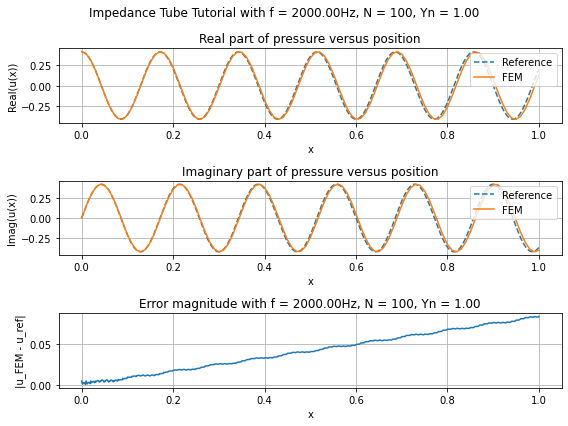

In [5]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(8, 6))
plt.suptitle('Impedance Tube Tutorial with f = {:.2f}Hz, N = {}, Yn = {:.2f}'.format(f, N, Yn))

plt.subplot(3, 1, 1)
plt.plot(x, np.real(uRef), '--', label='Reference')
plt.plot(x, np.real(uFEM), label='FEM')
plt.xlabel('x')
plt.ylabel('Real(u(x))')
plt.legend(loc='upper right')
plt.title('Real part of pressure versus position')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(x, np.imag(uRef), '--', label='Reference')
plt.plot(x, np.imag(uFEM), label='FEM')
plt.xlabel('x')
plt.ylabel('Imag(u(x))')
plt.legend(loc='upper right')
plt.title('Imaginary part of pressure versus position')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(x, np.abs(uRef - uFEM))
plt.xlabel('x')
plt.ylabel('|u_FEM - u_ref|')
plt.title('Error magnitude with f = {:.2f}Hz, N = {}, Yn = {:.2f}'.format(f, N, Yn))
plt.grid(True)

plt.tight_layout()
plt.show()